In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import os

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import cv2

from lstm.model import create_model
from lstm.loader import load_data, prepare_data
from lstm.train import train


if tf.config.list_physical_devices('GPU'):
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])

2023-05-25 12:09:37.688321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 12:09:38.412743: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-25 12:09:40.389889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-05-25 12:09:40.390241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot 

Num GPUs Available:  1


2023-05-25 12:09:42.831519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 12:09:43.073828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 12:09:43.074132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:

# Load data
data_dir = '/home/grete/Projects/ml-training-data/ammonium_perchlorate/output/ml-64-11'
rc_data_path = os.path.join(data_dir, 'rcs_input.npy')
gt_data_path = os.path.join(data_dir, 'gts_input.npy')

rc_test_path = os.path.join(data_dir, 'rc_tests_input.npy')
gt_test_path = os.path.join(data_dir, 'gt_tests_input.npy')

x_train, y_train, x_val, y_val = prepare_data(rc_data_path, gt_data_path)
rc_test_dataset, gt_test_dataset = load_data(rc_test_path, gt_test_path)

shape after loading: (1600, 11, 64, 64) (1600, 11, 64, 64)
shape after expand dimesnions: (1600, 11, 64, 64, 1) (1600, 11, 64, 64, 1)
Training Dataset Shapes: (1440, 10, 64, 64, 1), (1440, 10, 64, 64, 1)
Validation Dataset Shapes: (160, 10, 64, 64, 1), (160, 10, 64, 64, 1)
shape after loading: (20, 100, 64, 64) (20, 100, 64, 64)
shape after expand dimesnions: (20, 100, 64, 64, 1) (20, 100, 64, 64, 1)


Model training

In [4]:
model = create_model((None, *x_train.shape[2:]))

# memory allocation
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# checkpoint callbacks
checkpoint_path = "checkpoints/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5 # TODO: 25

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr, cp_callback],
)

2023-05-25 12:09:56.725581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 12:09:56.725780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 12:09:56.725896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 12:09:56.726055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 12:09:56.726172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Epoch 1/20


2023-05-25 12:10:02.112497: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8801
2023-05-25 12:10:04.546925: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


288/288 [==============================] - ETA: 0s - loss: 0.0148
Epoch 1: val_loss improved from inf to 0.09118, saving model to checkpoints/cp.ckpt
288/288 [==============================] - 69s 214ms/step - loss: 0.0148 - val_loss: 0.0912 - lr: 0.0010
Epoch 2/20
288/288 [==============================] - ETA: 0s - loss: 0.0039
Epoch 2: val_loss improved from 0.09118 to 0.00493, saving model to checkpoints/cp.ckpt
288/288 [==============================] - 61s 213ms/step - loss: 0.0039 - val_loss: 0.0049 - lr: 0.0010
Epoch 3/20
288/288 [==============================] - ETA: 0s - loss: 0.0037
Epoch 3: val_loss improved from 0.00493 to 0.00322, saving model to checkpoints/cp.ckpt
288/288 [==============================] - 62s 215ms/step - loss: 0.0037 - val_loss: 0.0032 - lr: 0.0010
Epoch 4/20
288/288 [==============================] - ETA: 0s - loss: 0.0036
Epoch 4: val_loss improved from 0.00322 to 0.00312, saving model to checkpoints/cp.ckpt
288/288 [==============================]

In [ ]:
checkpoint_path = "checkpoints/cp.ckpt"
# Load model from checkpoints
model = create_model((None, *x_train.shape[2:]))

# Restore the weights
model.load_weights(checkpoint_path)
model.summary()

Frame Prediction Visualizations

Choice index 0
5
1/1 [==============================] - 0s 23ms/step
6
1/1 [==============================] - 0s 26ms/step
7
1/1 [==============================] - 0s 27ms/step
8
1/1 [==============================] - 0s 26ms/step
9
1/1 [==============================] - 0s 25ms/step
10
1/1 [==============================] - 0s 27ms/step
11
1/1 [==============================] - 0s 24ms/step
12
1/1 [==============================] - 0s 32ms/step
13
1/1 [==============================] - 0s 32ms/step
14
1/1 [==============================] - 0s 28ms/step
15
1/1 [==============================] - 0s 25ms/step
16
1/1 [==============================] - 0s 24ms/step
17
1/1 [==============================] - 0s 23ms/step
18
1/1 [==============================] - 0s 26ms/step
19
1/1 [==============================] - 0s 34ms/step
20
1/1 [==============================] - 0s 25ms/step
21
1/1 [==============================] - 0s 26ms/step
22
1/1 [==============================] - 0s 26ms/step


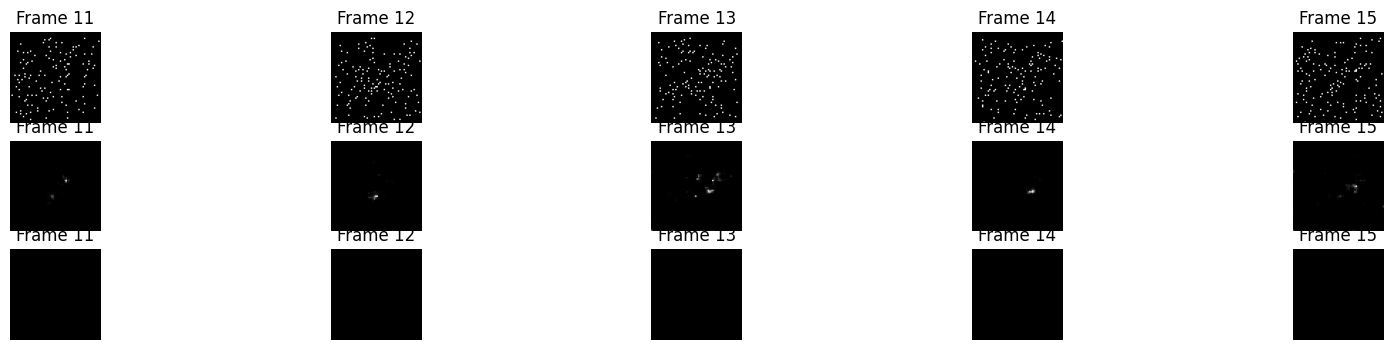

In [8]:
# Select a random example from the validation dataset.
choice_index = np.random.choice(range(len(rc_test_dataset)), size=1)[0]
rc_original_frames = rc_test_dataset[choice_index]
gt_original_frames = gt_test_dataset[choice_index]

#choice_index = 70
print('Choice index', choice_index)
predictions = []

level_names = []

for i in range(5, 100):
    # Extract the model's prediction and post-process it.
    # new_prediction = predict_fn(tf.constant(np.expand_dims(rc_original_frames, axis=0)))
    level_names.append(f'level_{i+1}.png')

    new_prediction = model.predict(np.expand_dims(rc_original_frames[i:i+5, ...], axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Predicted frames
    predictions.append(predicted_frame)

predictions = np.array(predictions)

prediction_dir = 'data/prediction/'
gt_dir = 'data/gt/'
binary_prediction_dir ='data/binary_prediction/'

os.makedirs(prediction_dir, exist_ok=True)
os.makedirs(gt_dir, exist_ok=True)
os.makedirs(binary_prediction_dir, exist_ok=True)
   
for i, prediction in enumerate(predictions):
    plt.imsave(os.path.join(prediction_dir, level_names[i]), np.squeeze(prediction), cmap='gray')
    plt.imsave(os.path.join(gt_dir, level_names[i]), np.squeeze(gt_original_frames[i+5]), cmap='gray')

    binary_im = np.zeros(shape=np.squeeze(prediction).shape[:2], dtype=int)
    binary_im[(np.squeeze(prediction) > 0.3)] = 1

    plt.imsave(os.path.join(binary_prediction_dir, level_names[i]), binary_im, cmap='gray')

In [ ]:
# Construct a figure for the original and new frames.
# fig, axes = plt.subplots(3, 5, figsize=(20, 4))

# # Plot the original frames.
# for idx, ax in enumerate(axes[0]):
#     ax.imshow(np.squeeze(rc_original_frames[idx + 5]), cmap="gray")
#     ax.set_title(f"Frame {idx + 11}")
#     ax.axis("off")

# # Plot the new frames.
# for idx, ax in enumerate(axes[1]):
#     ax.imshow(np.squeeze(predictions[idx]), cmap="gray")
#     ax.set_title(f"Frame {idx + 11}")
#     ax.axis("off")

# # Plot the gt frames.
# for idx, ax in enumerate(axes[2]):
#     ax.imshow(np.squeeze(gt_original_frames[idx + 5]), cmap="gray")
#     ax.set_title(f"Frame {idx + 11}")
#     ax.axis("off")

# # Display the figure.
# plt.show()